In [20]:
from utils import Graph
import scipy.interpolate as interpolate
import glob
import re
from matplotlib import pyplot as plt
import numpy as np

# Different pressure levels
P_v = [2, 7, 15]
N_v = [1.15e19, 4.02e19, 8.61e19]
colors = ['r', 'b', 'm']
colors_th = ['r--', 'b--', 'm--']

# Different cross section databases
databases = ['Biagi', 'BSR', 'Puech']
style = ['-', '-.', ':']

def alpha(P,E,A,B):
    return P * A * np.exp(-B*P/E)

def reduced_alpha(x, A,B):
    return A * np.exp(-B/x)

def M(alpha,dx):
    return np.exp(alpha * dx)

def psi_to_torr(p):
    return p * 51.7149

def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

In gaseous argon, the first Townsend coefficient $\alpha$ can be approximated by $\alpha = PAe^{-BP/E}$, where $A=14$ cm$^{-1}$ Torr$^{-1}$, $B=180$ V cm$^{-1}$ Torr$^{-1}$, $E$ is the electric field, and $P$ is the pressure (in Torr).

The total number of ionizations predicted by our simulation can be approximated by raising $2$ to the number of primary child ionizations. When plotting the multiplication per $10$ micrometers, we use $\frac{M}{10\mu{m}} = 2^{\frac{10n}{\Delta{x}}}$ where $\Delta{x}$ is measured in micrometers.

Since $M = e^{\alpha\Delta{x}}$ (where in this paragraph $\Delta{x}$ is measured in centimeters), we can estimate $\alpha$ with $\frac{\ln{M}}{\Delta{x}}$, or $\frac{n\ln(2)}{\Delta{x}}$ where $n$ is the number of primary child ionizations.

In [9]:
file_tree = [[{}, {}, {}], [{}, {}, {}]]

file_tree_total = [[[{}, {}, {}], [{}, {}, {}]], [[{}, {}, {}], [{}, {}, {}]], [[{}, {}, {}], [{}, {}, {}]]]

E_vals = [[[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]]]
alpha_vals = [[[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]]]
M_vals = [[[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]]]

v_vals = [[[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]]]
v_devs = [[[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]]]

eV_vals = [[[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]]]
eV_devs = [[[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]]]

for k, db in enumerate(databases):
    for j, d in enumerate([1, 3]):
        for i, p in enumerate(P_v):
            for file in glob.glob('townsend-graphs/' + db + '/%i-psi/%id/*.txt'%(p,d)):
                key = int(re.search(r'(\d*)(?:V)', file).group(1))
                if (key in file_tree_total[k][j][i]):
                    file_tree_total[k][j][i][key].append(file)
                else:
                    file_tree_total[k][j][i][key] = [file]

            for key, value in sorted(file_tree_total[k][j][i].items()):
                group = Graph(value)
                E_vals[k][j][i].append(key)
                alpha_vals[k][j][i].append(group.alpha(recursive=False))
                M_vals[k][j][i].append(group.M(recursive=False))
                v_vals[k][j][i].append(group.drift_mean())
                v_devs[k][j][i].append(group.drift_std_dev())
                eV_vals[k][j][i].append(group.eV_mean())
                eV_devs[k][j][i].append(group.eV_std_dev())

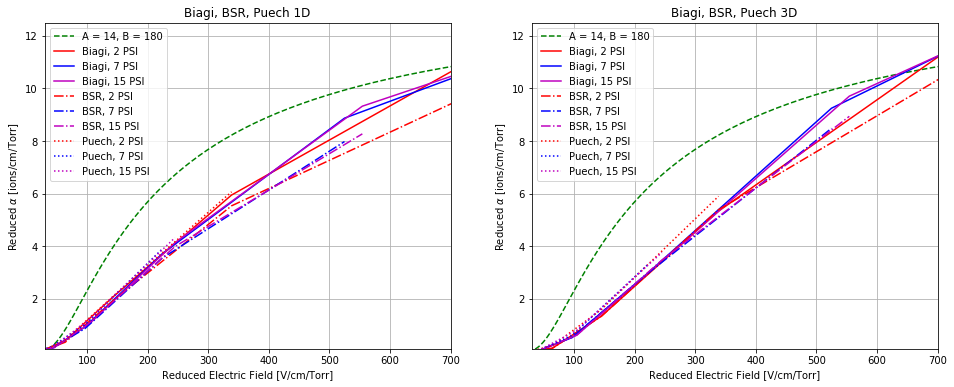

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

subplots = [ax1, ax2]
x_v = np.logspace(1,3,100)
alpha_red_v_1 = reduced_alpha(x_v, 14, 180)

for j, d in enumerate([1, 3]):
    subplots[j].plot(x_v, alpha_red_v_1, 'g--', label=r'A = 14, B = 180')
    for k, db in enumerate(databases):
        for i, p in enumerate(P_v):
            subplots[j].plot([v / psi_to_torr(p) for v in E_vals[k][j][i]], [a / psi_to_torr(p) for a in alpha_vals[k][j][i]], colors[i], linestyle=style[k], label='%s, %i PSI'%(db, p))
            subplots[j].set_title(', '.join(map(str, databases)) + ' %iD'%d)
            subplots[j].set_xlabel('Reduced Electric Field [V/cm/Torr]')
            subplots[j].set_ylabel('Reduced $\\alpha$ [ions/cm/Torr]')
            subplots[j].set_xlim(3e1, 7e2)
            subplots[j].set_ylim(1e-1, 1.25e1)
            subplots[j].legend()
            subplots[j].grid()

plt.show()

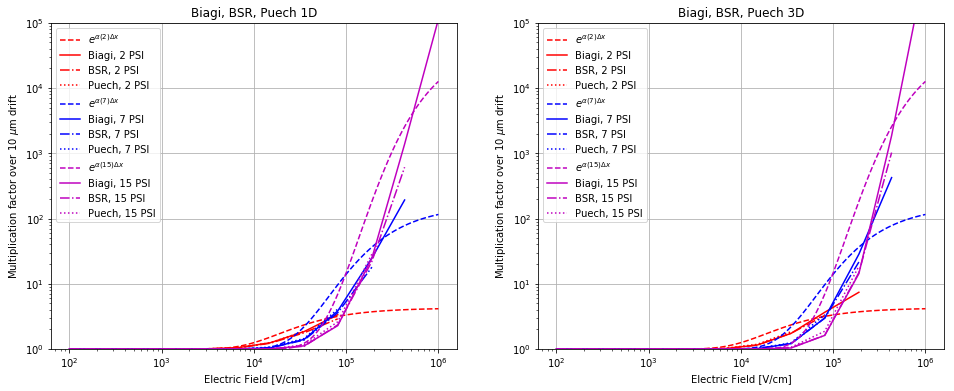

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

subplots = [ax1, ax2]

E_v = np.logspace(3, 6, 100)
for j, d in enumerate([1, 3]):
    for i, p in enumerate(P_v):
        a_v = alpha(psi_to_torr(p), E_v, 14, 180)
        mult_v = M(a_v, 10 * 1e-4)
        subplots[j].plot(E_v, mult_v, colors_th[i], label=r'$e^{\alpha(%i)\Delta{x}}$'%p)
        for k, db in enumerate(databases):
            subplots[j].plot(E_vals[k][j][i], M_vals[k][j][i], colors[i], linestyle=style[k], label='%s, %i PSI'%(db, p))
            subplots[j].set_xlabel('Electric Field [V/cm]')
            subplots[j].set_ylabel('Multiplication factor over 10 $\mu$m drift')
            subplots[j].set_xscale('log')
            subplots[j].set_yscale('log')
            subplots[j].set_ylim(1, 1e5)
            subplots[j].set_title(', '.join(map(str, databases)) + ' %iD'%d)
            subplots[j].legend()
            subplots[j].grid()

plt.show()

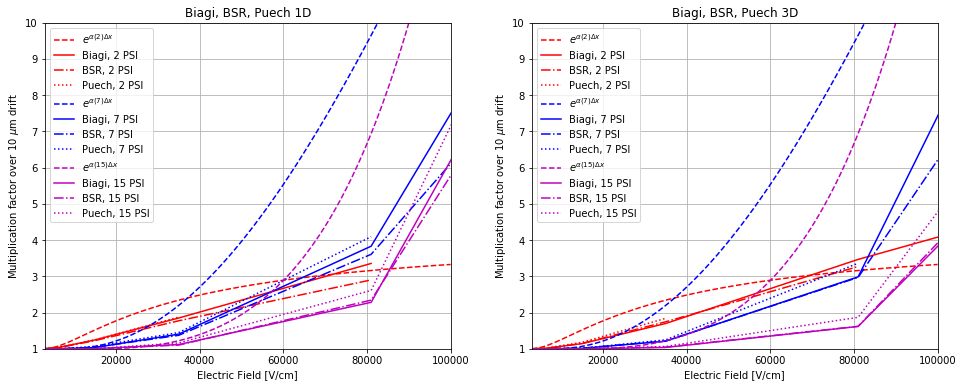

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

subplots = [ax1, ax2]

E_v = np.linspace(3e3, 1e5, 100)
for j, d in enumerate([1, 3]):
    for i, p in enumerate(P_v):
        a_v = alpha(psi_to_torr(p), E_v, 14, 180)
        mult_v = M(a_v, 10 * 1e-4)
        subplots[j].plot(E_v, mult_v, colors_th[i], label=r'$e^{\alpha(%i)\Delta{x}}$'%p)
        for k, db in enumerate(databases):
            subplots[j].plot(E_vals[k][j][i], M_vals[k][j][i], colors[i], linestyle=style[k], label='%s, %i PSI'%(db, p))
            subplots[j].set_xlabel('Electric Field [V/cm]')
            subplots[j].set_ylabel('Multiplication factor over 10 $\mu$m drift')
            subplots[j].set_xlim(3e3, 1e5)
            subplots[j].set_ylim(1, 1e1)
            subplots[j].set_title(', '.join(map(str, databases)) + ' %iD'%d)
            subplots[j].legend()
            subplots[j].grid()

plt.show()

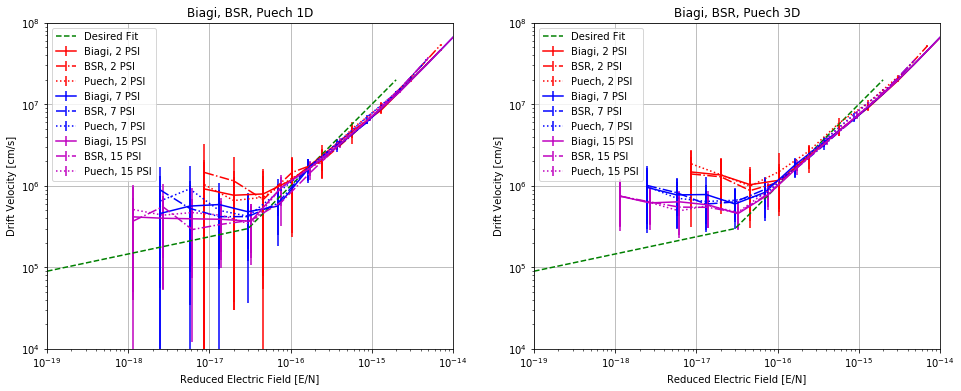

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

x = [1e-19, 3e-17, 2e-15]
y = [9e4, 3e5, 2e7]

data = log_interp1d(x, y)
x_vs = np.logspace(-19, np.log10(2e-15), 100)

subplots = [ax1, ax2]

for j, d in enumerate([1, 3]):
    subplots[j].plot(x_vs, data(x_vs), 'g--', label='Desired Fit')
    for i, p in enumerate(P_v):
        for k, db in enumerate(databases):
            subplots[j].errorbar([E / N_v[i] for E in E_vals[k][j][i]], [v * 1e2 for v in v_vals[k][j][i]], fmt=colors[i], yerr=[v * 1e2 for v in v_devs[k][j][i]], linestyle=style[k], label='%s, %i PSI'%(db, p))
            subplots[j].set_xlabel('Reduced Electric Field [E/N]')
            subplots[j].set_ylabel('Drift Velocity [cm/s]')
            subplots[j].set_xscale('log')
            subplots[j].set_yscale('log')
            subplots[j].set_xlim(1e-19, 1e-14)
            subplots[j].set_ylim(1e4, 1e8)
            subplots[j].legend()
            subplots[j].set_title(', '.join(map(str, databases)) + ' %iD'%d)
            subplots[j].grid()

plt.show()

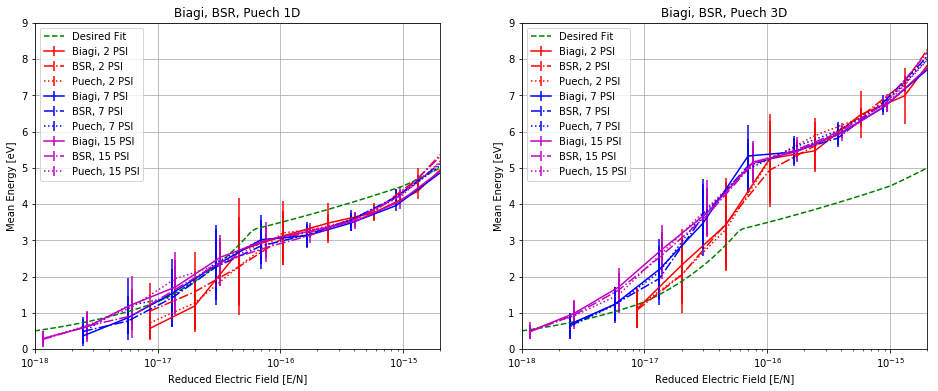

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

x = [1e-18, 1e-17, 6e-17, 1e-15, 2e-15]
y = [0.5, 1.3, 3.3, 4.5, 5]

data = log_interp1d(x, y)
x_vs = np.logspace(-18, np.log10(2e-15), 100)

subplots = [ax1, ax2]

for j, d in enumerate([1, 3]):
    subplots[j].plot(x_vs, data(x_vs), 'g--', label='Desired Fit')
    for i, p in enumerate(P_v):
        for k, db in enumerate(databases):
            subplots[j].errorbar([E / N_v[i] for E in E_vals[k][j][i]], eV_vals[k][j][i], fmt=colors[i], yerr=eV_devs[k][j][i], linestyle=style[k], label='%s, %i PSI'%(db, p))
            subplots[j].set_xlabel('Reduced Electric Field [E/N]')
            subplots[j].set_ylabel('Mean Energy [eV]')
            subplots[j].set_xscale('log')
            subplots[j].set_xlim(1e-18, 2e-15)
            subplots[j].set_ylim(0, 9)
            subplots[j].legend()
            subplots[j].set_title(', '.join(map(str, databases)) + ' %iD'%d)
            subplots[j].grid()

plt.show()